# **CIFAR 100 Image Classification**

### RICCARDO GALARDUCCI - $66819$

# **Introduction**
The aim of this colab notebook is to classify CIFAR-100 images using coarse labels. This will be accomplished by constructing two different types of models, a **Multi-Layer Perceptron** (MLP) and a **Convolutional Neural Network** (CNN), using the Sequential Model of Tensorflow Keras. We will provide an overview of the characteristics of both models and determine which of the two yields better generalization performance.

In [ ]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.datasets import cifar100
import random as python_random

# Set the seed values for reproducible results
seed_value=42

np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)

---
# **Exploratory Data Analysis**
We start with a brief  **exploratory Data Analysis** to gain the first insights into the data set. 

As first step we load the data set and, split it in training and a test set.

In [ ]:
# Loading cifar100 dataset and splitting it in training and test set
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="coarse")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


The training set is constituted by $50000$ images of size $32$x$32$x$3$. This is the typical shape of *rgb* images which are constituted by $3$ channels 'red', 'green' and 'blue'. Test set instead is constitued by $10000$ images

In [ ]:
# Checking the unique values of the target labels and counting their occurrences
tf.unique_with_counts(tf.squeeze(y_train))

UniqueWithCounts(y=<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([11, 15,  4, 14,  1,  5, 18,  3, 10, 17,  2,  9,  8, 16,  6, 12, 19,
        7, 13,  0])>, idx=<tf.Tensor: shape=(50000,), dtype=int32, numpy=array([ 0,  1,  2, ..., 12, 17,  4], dtype=int32)>, count=<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
       2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500], dtype=int32)>)

In the code above we have checker the number of classes of Cifar100 with coarse label. It counts 20 different labels.

In [ ]:
COARSE_LABEL_NAMES = [
    "aquatic_mammals",
    "fish",
    "flowers",
    "food_containers",
    "fruit_and_vegetables",
    "household_electrical_devices",
    "household_furniture",
    "insects",
    "large_carnivores",
    "large_man-made_outdoor_things",
    "large_natural_outdoor_scenes",
    "large_omnivores_and_herbivores",
    "medium_mammals",
    "non-insect_invertebrates",
    "people",
    "reptiles",
    "small_mammals",
    "trees",
    "vehicles_1",
    "vehicles_2",
]

**Plotting images**
In the code below we inspect the images, shows randomly eight of them with their name taken from COARSE_LABEL_NAMES. We can that the images are not high resolution, and this likely implies that the classification task will not be easy. 

<ipython-input-5-6e05ea985923>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  cifar_img = plt.subplot(4,4, i+1)


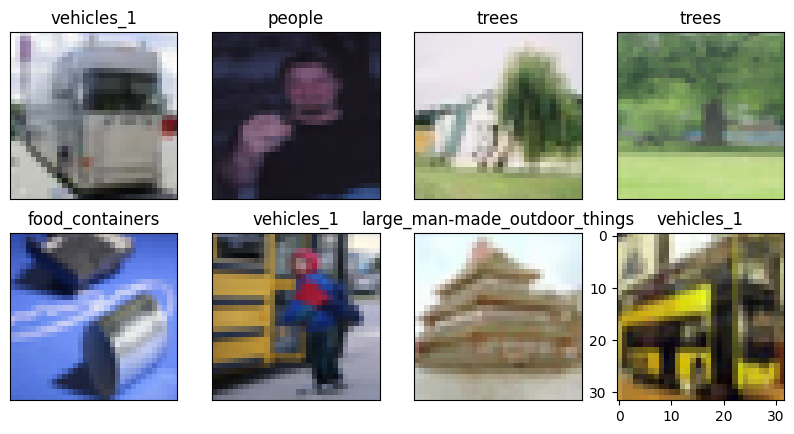

In [ ]:
# Show randomly 8 images from the dataset
plt.figure(figsize=(10, 10))
for i in range (8):
  rand_num = np.random.randint(0, y_train.shape[0])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(x_train[rand_num])
  plt.title(COARSE_LABEL_NAMES[int(y_train[rand_num])])


---
# **MLP - Multi Layer Perceptron**
We start trying to solve the classification task using a MLP. 

We first define a function which exploit the ```History``` object returned by the ```model.fit()``` method of keras models. ```History``` contains *loss* (training loss), 'acc' (training accuracy), 'val_loss' (validation loss), 'val_acc' (validation accuracy). These are metrics that can be used to assess the performance of a model, specifically to determine whether the model is experiencing *overfitting* or *underfitting*.


In [ ]:
# Training plot
def training_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)

  # Training and validation loss
  axes[0].plot(epochs, loss, marker="o", label='Training loss', linestyle='dashed', color='royalblue')
  axes[0].plot(epochs, val_loss, marker="o", label='Validation loss', linestyle='dashed', color='darkorange')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].legend()
  
  # Training and validation accuracy
  axes[1].plot(epochs, acc, marker="o", label='Training acc', linestyle='dashed', color='royalblue')
  axes[1].plot(epochs, val_acc, marker="o", label='Validation acc', linestyle='dashed', color='darkorange')
  axes[1].set_title('Training and Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].legend()
  
  plt.show()

## **Normaliziation** 
**Normalization** is a data preprocessing technique used in machine learning that scales the input features to a common range. It can have several effects on the model, such as improving convergence speed, reducing the probability of getting stuck in local minima, and preventing certain features from dominating the learning process. Overall, normalization can lead to better performance and more reliable results in machine learning models.

Each channel can takes values between $0$ and $255$, to normalize the data we divide them by $255$ in order to have values ranging from $0$ to $1$.

In [ ]:
# Normalize images
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

train_labels = y_train
test_labels = y_test

## **How to build a MLP with Sequential class in keras**
**Sequential class** groups a linear stack of layers into a ```tf.keras.Model```. 
1. The first step to do is initialize the model this is done with ```tf.keras.Sequential()```. 
2. Then through ```.add()``` method we can add layer instances on top of the layer stack. We can add layers one by one as in the example below.


There are different types of layers, the regular fully connected layer is ```tf.keras.layers.Dense```class. It takes many arguments useful to tune the layer such as:
-  **number of units**: define the number of hidden units in the layer.
-  **activation function** (by default no activation is applied, i.e. linear activation: $f(x) = x$.
- **kernel initializer**: initialization strategy for the weights, the default is *glorot uniform*.



We start building a MLP with the following architecture:
- $4$ **hidden layers** with $32$, $64$, $64$, $32$ hidden units respectively.
- an **output layer** with $20$ output units. The ouput layer must have a number of units equal to the number of labels to predict, in the CIFAR100 dataset with coarse label we saw in the exploratory analysis that we have 20 labels.

Each layer applies a *ReLU* activation function to the *net*, which is the standard activation function for deep networks because allow to overcome the problem of *gradient vanish* which affect the *sigmoid* activation function.


A good weights initialization strategy should  not reduce or magnify input signals exponentially. We explot *He Normal* which is specifically designed for *ReLU*. It draws samples from a truncated normal distribution centered on 0 with stddev = $\sqrt(\frac{2}{fan_{in}})$ where fan_in is the number of input units in the weight tensor. 

In [ ]:
# MLP 1

# Building the model with the Sequential class
model = keras.Sequential()

initializer=tf.keras.initializers.HeNormal(seed=42)
activation='relu'

# Adds a layer instance on top of the layer stack.
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(units=32, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=32, activation=activation, kernel_initializer=initializer))

# Output layer with 20 units as the number of classes
model.add(layers.Dense(units=20)) 

# summary method prints a string summary of the network.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 32)                98336     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 20)                660       
                                                                 
Total params: 107,348
Trainable params: 107,348
Non-tr

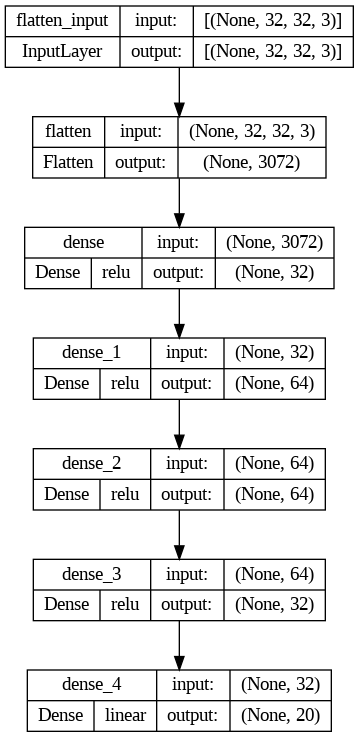

In [ ]:
# Plotting the model architecture
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       show_layer_activations=True)

## **Training the model**
There are two steps to follow in order to train the model:

1. **compile** the model: ```.compile()``` method compile the model and allow to configure **optimizer**, **loss function** and **metrics**. 

2. **fit** the model to data: fitting the model is done with ```.fit()``` method which returns a History object. Its ```History.history``` attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.
It takes several arguments as the **batch size**, the **split ratio** between training set and validation set and the number of **epochs** to run during training.

We decide to use **Stochastic Gradient Descent** as optimizers

The loss function suitable for our task is the **Sparse Categorical Cross Entropy** which omputes the cross-entropy loss between true labels and predicted labels. It's the loss function suggested when there are two or more label classes provided as integers.

We set the **accuracy** as metric to be evaluated by the model during training

In [ ]:
# Compiling the model allow to configure the model with losses and metrics
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,
                                                momentum=0.0,
                                                nesterov=False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # metrics to be evaluated by the model during training

## **Early Stopping**

**Early stopping** is a regularization technique used in machine learning to prevent overfitting of the model. Overfitting occurs when the model learns the training data too well, resulting in poor performance on unseen data.

Early stopping involves monitoring the performance of the model on a validation set during training, and stopping the training process when the performance on the validation set starts to degrade. The callback we have defined will stop the training when there is no improvement in the validation loss for three consecutive epochs ```patience=3```.

Early Stopping also reduce the amount of time required to train models.

In [ ]:
# Fitting the model to data
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=train_images, 
                    y=y_train,
                    batch_size=None,        # Number of samples per gradient update (if batch_size=None then default=32)
                    validation_split=0.2,
                    shuffle=True,           # whether to shuffle the training data before each epoch
                    epochs=50,              # maximum number of epochs
                    callbacks=[callback])               

Epoch 1/50
1250/1250 [==============================] - 11s 4ms/step - loss: 2.9173 - accuracy: 0.0859 - val_loss: 2.8520 - val_accuracy: 0.1039
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.7804 - accuracy: 0.1436 - val_loss: 2.6766 - val_accuracy: 0.1796
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.6075 - accuracy: 0.1905 - val_loss: 2.5404 - val_accuracy: 0.2109
Epoch 4/50
1250/1250 [==============================] - 6s 4ms/step - loss: 2.5157 - accuracy: 0.2188 - val_loss: 2.4926 - val_accuracy: 0.2272
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.4637 - accuracy: 0.2326 - val_loss: 2.4436 - val_accuracy: 0.2427
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.4264 - accuracy: 0.2445 - val_loss: 2.4056 - val_accuracy: 0.2576
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3985 - accuracy: 0.2552 - val_loss: 2.4212 - val_accuracy

## **Model evaluation**
In order to evaluate the model we plot training and validation loss with respect to the training epochs (proxy of the model complexity). The model reach poor generalization performances, the maximum accuracy is $≈ 32\%$. The optimization algorithm takes 35 epochs to stop, training and validation losses progressively decrease till validation loss start to remian stable and after three epochs the algorithm end because of early stopping before likely start to overfit data.

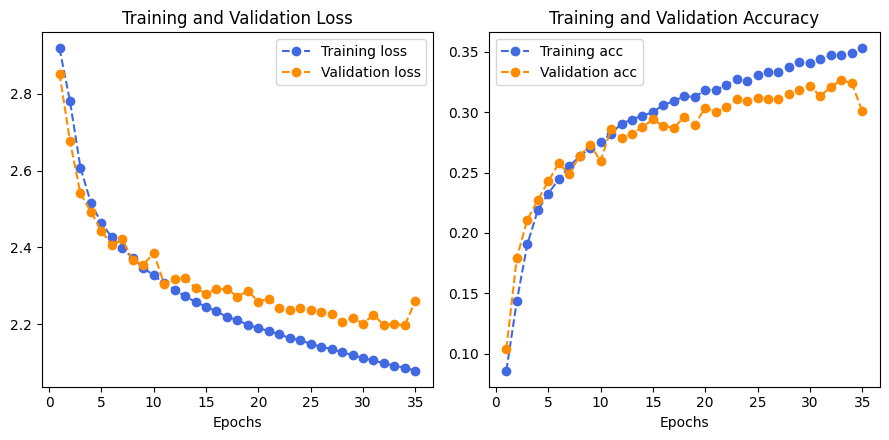

In [ ]:
training_plot(history)

## **Increasing model complexity**

What if we increase model complexity by building a deeper and wider model? A more complex model is able to capture more intricate patterns in the data and provide better predictions. However, increasing model complexity can also lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new, unseen data. This can result in a decrease in the model's ability to generalize and make accurate predictions.

What happen to the validation error and accuracy? 

The $2°$ model we build has $6$ hidden layers, the number of hidden units are respectively $64, 128, 256, 256, 128, 64$. The other setting remains unchanged.

Let's see what happens

In [ ]:
# MLP 2
model = keras.Sequential()

initializer=tf.keras.initializers.HeNormal(seed=42)
activation='relu'


# Adds a layer instance on top of the layer stack.
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=128, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=256, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=256, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=128, activation=activation, kernel_initializer=initializer))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))

# Output layer with 20 units as the number of classes
model.add(layers.Dense(units=20))

# summary method prints a string summary of the network.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                196672    
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,
                                                momentum=0.0,
                                                nesterov=False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [ ]:
# Fitting the model to data
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=train_images, 
                    y=y_train,
                    batch_size=None,        
                    validation_split=0.2,
                    shuffle=True,           
                    epochs=50,             
                    callbacks=[callback])  

Epoch 1/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.7051 - accuracy: 0.1602 - val_loss: 2.5465 - val_accuracy: 0.2111
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.5108 - accuracy: 0.2218 - val_loss: 2.4640 - val_accuracy: 0.2343
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.4249 - accuracy: 0.2494 - val_loss: 2.3859 - val_accuracy: 0.2642
Epoch 4/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.3641 - accuracy: 0.2693 - val_loss: 2.3553 - val_accuracy: 0.2746
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3189 - accuracy: 0.2807 - val_loss: 2.3480 - val_accuracy: 0.2768
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2767 - accuracy: 0.2956 - val_loss: 2.2583 - val_accuracy: 0.3070
Epoch 7/50
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2441 - accuracy: 0.3061 - val_loss: 2.2838 - val_accuracy:

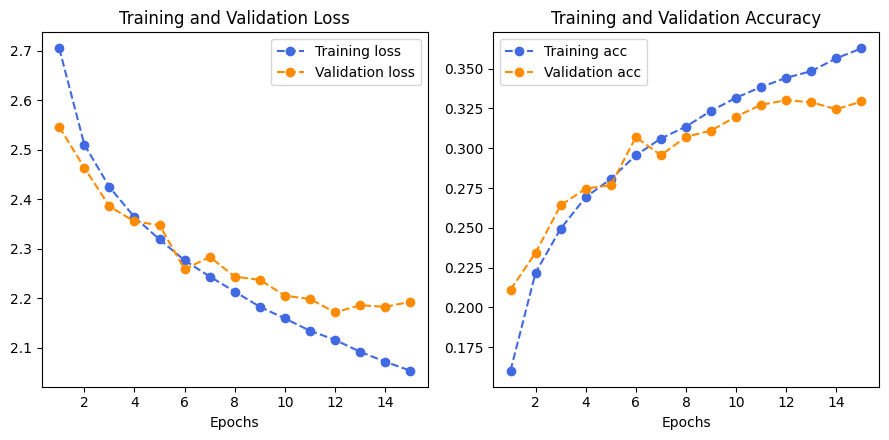

In [ ]:
training_plot(history)

This second MLP has $346,260$ of tot trainable parameters while the first one has $107,348$ tot trainable parameters, it means that it has approximately three times the number of parameters than the first one.

The algorithm stops after 15 epochs but the validation loss' lower value is a little bit higher wrt to the first model while the validation accuracy does not reach significant improvements wrt the first model.

To reduce iverfitting we can exploit regularization techniques such as adding penalty terms to the loss function or adding dropout.

## **Regularization**

**Regularization** in machine learning is a technique used to address the problem of overfitting, where a model learns the noise in the training data instead of the underlying patterns. We will see two regularization techniques:

1. Adding a **penalty term** to the loss function
2. **Dropout**


### **Penalty Term**

Regularization works by adding a penalty term to the loss function that the model optimizes, which discourages the model from learning complex patterns that may not generalize well to new data. 
In keras tensorflow we can specify **L1** regularization or **L2** regularization directly in the layer. In particular we can apply a penalty term both on the **layer's kernel** and the **layer's output**
```python
kernel_regularizer=tf.keras.regularizers.L1(0.01) "Regularizer to apply a penalty on the layer's kernel"
 activity_regularizer=tf.keras.regularizers.L2(0.01) "Regularizer to apply a penalty on the layer's output"
```
There are few issues that can arise when adding a penalty term to the loss function:
- **Over-regularization**: If the regularization term is too strong, it can cause the model to underfit and not capture the underlying patterns in the data. This can lead to poor performance on both the training and test sets.

- **Slow convergence**: Adding a regularization term can slow down the convergence of the optimization algorithm, especially if the regularization strength is high. This can increase the time required to train the model and may make it harder to optimize the hyperparameters.



### **Dropout**

Another way to regularize the model is Dropout. 

**Dropout** is a regularization technique commonly used in neural networks to prevent overfitting. It involves randomly dropping out (i.e., setting to zero) some of the neurons during each training iteration.

The idea behind dropout is that it encourages the network to learn more robust features by preventing neurons from co-adapting too much to each other. By randomly dropping out neurons, the network is forced to rely on a subset of neurons for making predictions, which reduces the risk of overfitting.

In the following model we add Dropout with a 0.2 rate.

```python
model.add(layers.Dropout(rate=0.2))
```

In [ ]:
# MLP 3
model = keras.Sequential()

initializer=tf.keras.initializers.HeNormal(seed=42)
activation='relu'


# Adds a layer instance on top of the layer stack.
model.add(layers.Flatten(input_shape=(32, 32, 3)))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=128, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=256, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=256, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=128, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation=activation, kernel_initializer=initializer))
model.add(layers.Dropout(rate=0.2))

# Output layer with 20 units as the number of classes
model.add(layers.Dense(units=20))

# summary method prints a string summary of the network.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                196672    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,
                                                momentum=0.0,
                                                nesterov=False),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In [ ]:
# Fitting the model to data
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x=train_images, 
                    y=y_train,
                    batch_size=None,        
                    validation_split=0.2,
                    shuffle=True,           
                    epochs=50,             
                    callbacks=[callback]) 

Epoch 1/50
1250/1250 [==============================] - 7s 4ms/step - loss: 2.9680 - accuracy: 0.0732 - val_loss: 2.8940 - val_accuracy: 0.0849
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.9129 - accuracy: 0.0873 - val_loss: 2.8648 - val_accuracy: 0.0968
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.8753 - accuracy: 0.0943 - val_loss: 2.8386 - val_accuracy: 0.1025
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.8413 - accuracy: 0.1001 - val_loss: 2.7986 - val_accuracy: 0.1159
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.8155 - accuracy: 0.1093 - val_loss: 2.7870 - val_accuracy: 0.1239
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.7959 - accuracy: 0.1146 - val_loss: 2.7945 - val_accuracy: 0.1197
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.7857 - accuracy: 0.1168 - val_loss: 2.7691 - val_accuracy:

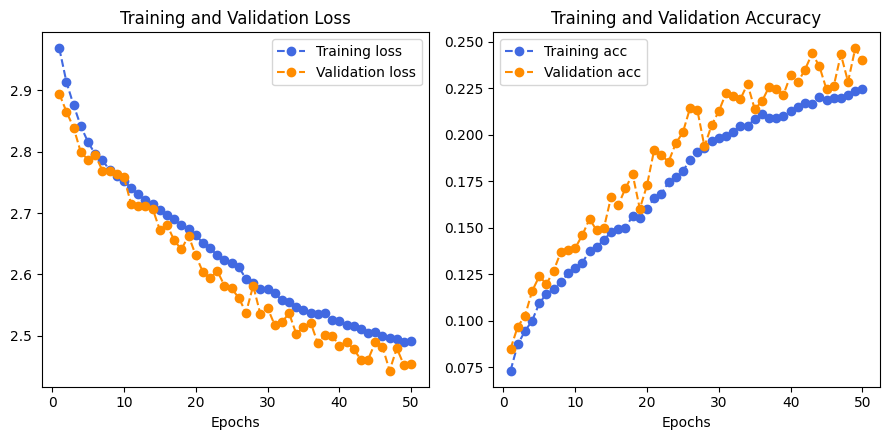

In [ ]:
training_plot(history)

We can see in the plot above that during training, dropout can lead to a more noisy and fluctuating validation loss compared to a model without dropout. This is because each training iteration randomly drops out different neurons, which can affect the output of the model and make the validation loss more variable. 

Moreover if we compare the model with and without dropout we can see that the latter reach highest generalization performances. Likely we add too much dropout which cause the model to underfit and result in a higher validation loss and low validation accuracy

## **Random Search - Tuning model architecture and hyperparameters setting**

To tune model's hyperparameters in order to find the better model configuration that strike a good trade-off between model complexity and regularization we need to do it empirically and test different settings. 

Exploring all different settings is computationally expansive and time consuming. A strategy to reduce the effort is to define a grid of hyperparameter settings (**search space**) to test and to explore them randomly, this strategy is called **Random Search**. \

Below we will se a way to implement it using **KerasTuner library**


We define a ```build_model()``` function which returns a compiled Keras model. It takes an argument hp for defining the hyperparameters while building the model.

We have defined different hyperparameters value to test. In particular:

- **number of units**: 32, 64, 128, 256, 512.
- **activation function**: relu, elu, swish 
- **weights initializations strategies** He normal, LeCun normal, Glorot normal
- **dropouts layer** with p=0.2 concerning every hidden layer
- **optimizers**: SGD, Adam

Also the architecture of the model is tuned, the number of hidden layers vary from 3 to 6.

### **Activation Function**
The choice of the activation function can be crucial for the performances of a model. We decided to try ELU (Exponential Linear Unit) and Swish which are two valid alternatives to the popular ReLU (Rectified Linear Unit) function.
Some properties of ELU and Swish compared to ReLU:

- **Smoothness**: Unlike ReLU, ELU and Swish are smooth functions, meaning they have continuous derivatives. This can be beneficial in some cases, especially when optimizing using gradient-based methods.

- **Range**: ReLU outputs zero for negative inputs, which can cause *dead neurons* in the network where the gradient is zero and the neuron stops learning. ELU and Swish have non-zero outputs for all inputs, which can help avoid this problem.

- **Saturation**: ReLU can saturate when the input is large, meaning the output becomes constant and the gradient is zero. ELU and Swish have a more gradual saturation, which can help improve the robustness of the network.


In [ ]:
# installing and importing keras_tuner
!pip install keras_tuner

import keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(32, 32, 3)))
    for i in range(hp.Int('num_layers', 3, 6)):
        model.add(layers.Dense(units=hp.Choice(f'units_{i}', [32, 64, 128, 256, 512]),
                        activation=hp.Choice("activation", ["relu", "elu", "swish"]),
                        kernel_initializer=hp.Choice("kernel_initializer", ['HeNormal' ,'LecunNormal', 'GlorotNormal'])
                        ))
        if hp.Boolean("dropout"): model.add(layers.Dropout(rate=0.2))
        
    model.add(layers.Dense(units=20))

    model.compile(optimizer=hp.Choice("optimizer", ["SGD", "Adam"]),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

build_model(keras_tuner.HyperParameters())

### **Tuner**
After having specified the search space we define the ```keras_tuner.RandomSearch()``` Random Search tuning algorithm with: 
- **max number of trials** that are the number of model configurations to test.
- the **objective function** to optimize 
- **executions per trial**. The number of models that should be built and fit for each trial. Different trials have different hyperparameter values. The executions within the same trial have the same hyperparameter values. The purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model.


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    executions_per_trial=1,
    max_trials=50,  # total number of trials (model configurations) to test at most
    overwrite=True
    )


In [ ]:
# Summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu', 'swish'], 'ordered': False}
kernel_initializer (Choice)
{'default': 'HeNormal', 'conditions': [], 'values': ['HeNormal', 'LecunNormal', 'GlorotNormal'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
units_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512], 'ordered': True}
units_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256, 512], 'ordered': True}
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}


In [ ]:
# Start the search for the best hyperparameter configuration

# This callback will stop the training when there is no improvement the validation loss for three consecutive epochs.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_images, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 50 Complete [00h 02m 14s]
val_accuracy: 0.30410000681877136

Best val_accuracy So Far: 0.3646000027656555
Total elapsed time: 01h 53m 55s


### **Query the results of the search**
We can retrieve the best models (according to the objective function we have defined) 

In [ ]:
# Summary of the search results
tuner.results_summary()

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters 
model = tuner.hypermodel.build(best_hps)

# Model summary
model.summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
num_layers: 6
units_0: 512
activation: swish
kernel_initializer: HeNormal
dropout: False
units_1: 512
units_2: 512
optimizer: SGD
units_3: 512
units_4: 64
units_5: 256
Score: 0.3646000027656555

Trial 45 summary
Hyperparameters:
num_layers: 6
units_0: 128
activation: swish
kernel_initializer: LecunNormal
dropout: False
units_1: 32
units_2: 512
optimizer: SGD
units_3: 64
units_4: 32
units_5: 512
Score: 0.3628000020980835

Trial 16 summary
Hyperparameters:
num_layers: 5
units_0: 64
activation: swish
kernel_initializer: GlorotNormal
dropout: False
units_1: 256
units_2: 256
optimizer: SGD
units_3: 64
units_4: 512
units_5: 128
Score: 0.3619000017642975

Trial 38 summary
Hyperparameters:
num_layers: 3
units_0: 128
activation: swish
kernel_initializer: LecunNormal
dropout: False
units_1: 256
units_2: 32
optimizer: SGD
units_3: 256
units_4: 64


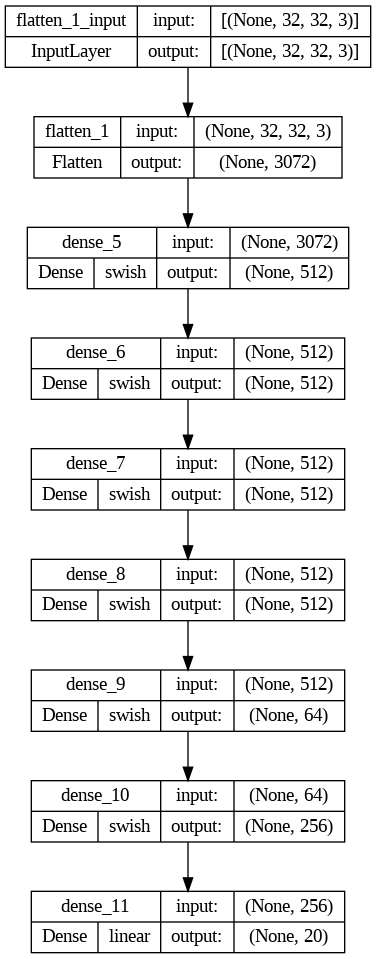

In [ ]:
# Plotting the model architecture
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       show_layer_activations=True)

In [ ]:
history = model.fit(train_images, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 7s 6ms/step - loss: 2.4340 - accuracy: 0.2442 - val_loss: 2.3545 - val_accuracy: 0.2711
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3335 - accuracy: 0.2766 - val_loss: 2.3876 - val_accuracy: 0.2738
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2669 - accuracy: 0.2971 - val_loss: 2.2755 - val_accuracy: 0.2994
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 2.2129 - accuracy: 0.3133 - val_loss: 2.2137 - val_accuracy: 0.3187
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.1664 - accuracy: 0.3273 - val_loss: 2.1931 - val_accuracy: 0.3245
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.1209 - accuracy: 0.3426 - val_loss: 2.1780 - val_accuracy: 0.3311
Epoch 7/50
1250/1250 [==============================] - 8s 6ms/step - loss: 2.0832 - accuracy: 0.3541 - val_loss: 2.1407 - val_accuracy:

In [ ]:
# Check the epoch with the best validation accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 10


In [ ]:
# Re-instantiate the model to train it with the optimal number of epochs
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_images, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 8s 5ms/step - loss: 2.6877 - accuracy: 0.1702 - val_loss: 2.5105 - val_accuracy: 0.2245
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.4458 - accuracy: 0.2427 - val_loss: 2.4470 - val_accuracy: 0.2477
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.3423 - accuracy: 0.2750 - val_loss: 2.2966 - val_accuracy: 0.2900
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2722 - accuracy: 0.2971 - val_loss: 2.2567 - val_accuracy: 0.3019
Epoch 5/10
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2183 - accuracy: 0.3130 - val_loss: 2.2368 - val_accuracy: 0.3115
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1697 - accuracy: 0.3273 - val_loss: 2.1902 - val_accuracy: 0.3236
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 2.1250 - accuracy: 0.3418 - val_loss: 2.1742 - val_accuracy:

### **Evaluate the best  hypermodel on the test set**

We evaluate the best hypermodel on the test set

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = hypermodel.evaluate(test_images, test_labels, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = hypermodel.predict(x_test[:3])
print("predictions shape:", predictions.shape)


Evaluate on test data
79/79 [==============================] - 0s 4ms/step - loss: 2.1616 - accuracy: 0.3353
test loss, test acc: [2.1616265773773193, 0.3352999985218048]
Generate predictions for 3 samples
1/1 [==============================] - 0s 17ms/step
predictions shape: (3, 20)


--- 
# **CNN - Convolutional Neural Network**

Until now, we've ignored the structure of images and treated them as vectors of numbers by flattening them. This approach was necessary in order to feed the resulting one-dimensional vectors to a fully connected MLP, which are designed to work mainly with tabular data. \\
MLP's result for image classification were deeply unsatisfied because of the loss of information.


> *Golden Rule*: adapt the model to the data and not the opposite

In the following section we will use **CNN - Convolutional Neural Network** which take their name from the *convolution operator*, and are designed to handle and exploit the structure of images to build more efficient and high-performance models.

#### **CNN Properties**
1. **Local connectivity**: CNNs exploit the local spatial correlations present in images by using convolutional layers that apply a set of filters to small regions of the input image, instead of processing each pixel independently like MLPs. This allows CNNs to capture spatial information in images, such as edges, corners, and textures, and to extract features that are *invariant* to *translation*, *rotation*, and *scaling*.


2. **Parameter sharing**: CNNs use the same set of weights (parameters) for each location in the image that a filter is applied to, reducing the number of parameters needed to be learned compared to MLPs. This lead to more efficient models. 


3. **Hierarchical representation learning**: CNNs are composed of multiple layers of filters that learn increasingly abstract representations of the input image. The *lower layers* capture local features such as edges and corners, while the *higher layers* capture more complex features such as object parts and textures. This hierarchical representation learning allows CNNs to learn rich and discriminative features for image classification tasks.

## **How to build a CNN**

**CNN architecture** is typically constitued by a composition of:
1. **Convolutional layer** which apply the *convolution operator* to the input. It usally also apply an *activation function* to the outcome of the convolution operator. The output is called *feature map*. \\
In keras Sequential class the 2D convolution layer is defined as follow:

```python
tf.keras.layers.Conv2D(filters,      # the number of output filters in the convolution
                      kernel_size,   # specifying the height and width of the 2D convolution window
                      strides,       # step size when moving the kernel along the input
                      padding,       # size of zeroed frame added around the input
                      dilation_rate) # expansion of the filters
```




2. **Pooling layers** which reduce the spatial resolution of the feature maps generated by the convolutional layers, while retaining the most important information. This helps to reduce the impact of small variations in the input image, making the model more robust to noise and small distortions. It does not increase the number of free parameters. \\
There are two types of convolutional layer depending on the operation they compute on the feature maps, *max pooling* or *average pooling*. 

```python
tf.keras.layers.MaxPooling2D(pool_size)    #  window size over which to take the maximum. 
                                           # (2, 2) will take the max value over a 2x2 pooling window.

tf.keras.layers.AveragePooling2D(pool_size) #  window size over which computing the average. 
                                            # (2, 2) will compute the average value over a 2x2 pooling window.
```




3. **Fully connected layer(s)**: the head of a CNN is constited by one or more fully connected layers and an output layer which has the same number of units as the labels to predict. The last feature maps coming from the CNN body must be flatten to pass it to the fully connected layer.

We start by building a basic CNN it is a composition of $3$ blocks each of them composed by one Convolutional layer and one Pooling layer (max pooling).
- Each convolution layer has several filters ($32, 64, 128$): the higher the number of filters, the higher the number of abstractions that the network is able to extract from image data.
- The number of filters encrease with model depth. That's because every layer of filters is there to capture patterns. For example, the first layer of filters captures patterns like edges, corners, dots etc. Subsequent layers combine those patterns to make bigger patterns. As we move forward in the layers, the patterns get more complex, hence there are larger combinations of patterns to capture. That's why we increase the filter size in subsequent layers to capture as many combinations as possible.

We use **ReLU** activation function and the **he normal** weights initializer. The kernel size is $3$x$3$. \\
The head is composed by two fully connected layers and an output layer 

In [ ]:
# CNN 1
model = keras.Sequential()

initializer="he_normal"
activation='relu'

# The composition of Convolutional and Pooling layer works as feature ectractors
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3))) # Normalization layer
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, kernel_initializer=initializer)) # Convolutional layer
model.add(layers.MaxPooling2D((2, 2))) # Max pooling layer 2x2

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, kernel_initializer=initializer)) # Convolutional layer
model.add(layers.MaxPooling2D((2, 2))) # Max pooling layer 2x2

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, kernel_initializer=initializer)) # Convolutional layer
model.add(layers.MaxPooling2D((2, 2))) # Max pooling layer 2x2

# Head composed by fully connected layer
model.add(layers.Flatten())  # Flatten the feature map of the last convolutional layer to pass it to the head
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    # 1° fully connected layer
model.add(layers.Dense(20)) # Output Layer

In [ ]:
# summary of the network.
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliza  (None, 32, 32, 3)        7         
 tion)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_123 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                     

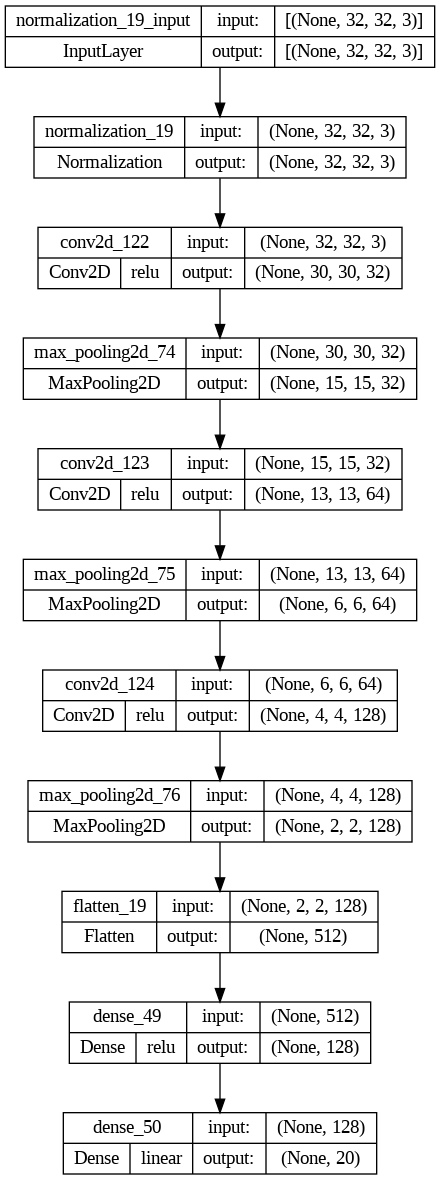

In [ ]:
# Plotting model architecture
keras.utils.plot_model(model, 
                       show_shapes=True, 
                       show_layer_activations=True)

**Compilation** \\
The model is compiled using:
- **SGD** optimizer
- **Sparse Categorical Crossentropy** loss function
- **accuracy** metric to evaluate the model

We use **early stopping** as callback to avoid overfitting and reduce time required for training

In [ ]:
# Compiling the model 
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Early stopping callback with patience =3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 8s 6ms/step - loss: 2.6705 - accuracy: 0.1768 - val_loss: 2.5105 - val_accuracy: 0.2260
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.4117 - accuracy: 0.2594 - val_loss: 2.3630 - val_accuracy: 0.2749
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2723 - accuracy: 0.3001 - val_loss: 2.2272 - val_accuracy: 0.3173
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.1729 - accuracy: 0.3312 - val_loss: 2.1753 - val_accuracy: 0.3200
Epoch 5/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0849 - accuracy: 0.3567 - val_loss: 2.0868 - val_accuracy: 0.3539
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0158 - accuracy: 0.3768 - val_loss: 2.0150 - val_accuracy: 0.3741
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9547 - accuracy: 0.3956 - val_loss: 1.9921 - val_accuracy:

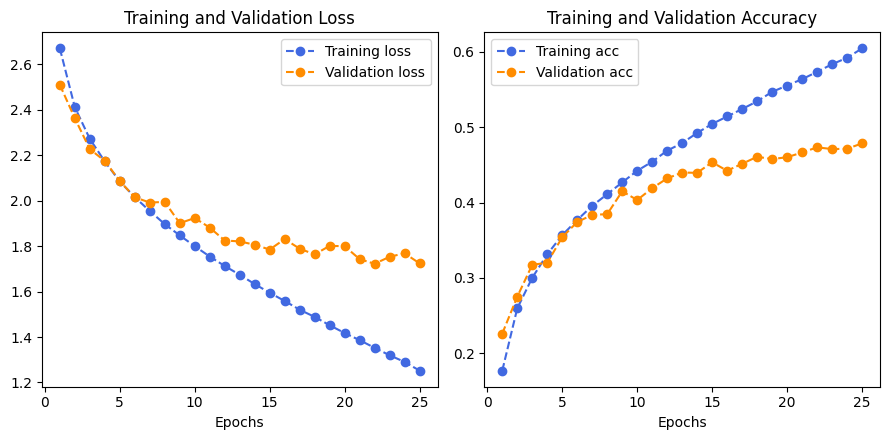

In [ ]:
training_plot(history_cnn)

**Model Evaluation: CNN vs MLP** \\
As a first shot, without any hyperparameter tuning and without any regularization techinques CNN reach a validation accuracy close to $0.48$. Comparing this results with the MLP is clear how CNN is more suitable for image classification tasks.


## **Padding**

Using a kernel on our image, the output’s size gets reduced and this happens progressively through the various layers. It means loosing information and especially at the boarders information is barely used.
To avoid this we use **padding** which consists to add extra dimensions to the image and fill them with 0. This should lead to exploit all information present in the image. It also has a second goal, be able to use deeper models.

We set ```padding = "same"```  to obtain an output which has the same size as the input.



In [ ]:
model = keras.Sequential()

initializer="he_normal"
activation='relu'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers (head of the model)
model.add(layers.Flatten())  
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    
model.add(layers.Dense(20)) 

In [ ]:
# summary method prints a string summary of the network.
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_20 (Normaliza  (None, 32, 32, 3)        7         
 tion)                                                           
                                                                 
 conv2d_125 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_126 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                     

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 8s 5ms/step - loss: 2.6567 - accuracy: 0.1852 - val_loss: 2.4443 - val_accuracy: 0.2593
Epoch 2/50
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3456 - accuracy: 0.2836 - val_loss: 2.2757 - val_accuracy: 0.3009
Epoch 3/50
1250/1250 [==============================] - 6s 4ms/step - loss: 2.1805 - accuracy: 0.3314 - val_loss: 2.1328 - val_accuracy: 0.3474
Epoch 4/50
1250/1250 [==============================] - 7s 6ms/step - loss: 2.0591 - accuracy: 0.3672 - val_loss: 2.0434 - val_accuracy: 0.3670
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9563 - accuracy: 0.3953 - val_loss: 1.9542 - val_accuracy: 0.3964
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8732 - accuracy: 0.4221 - val_loss: 1.9036 - val_accuracy: 0.4101
Epoch 7/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7960 - accuracy: 0.4433 - val_loss: 1.8740 - val_accuracy:

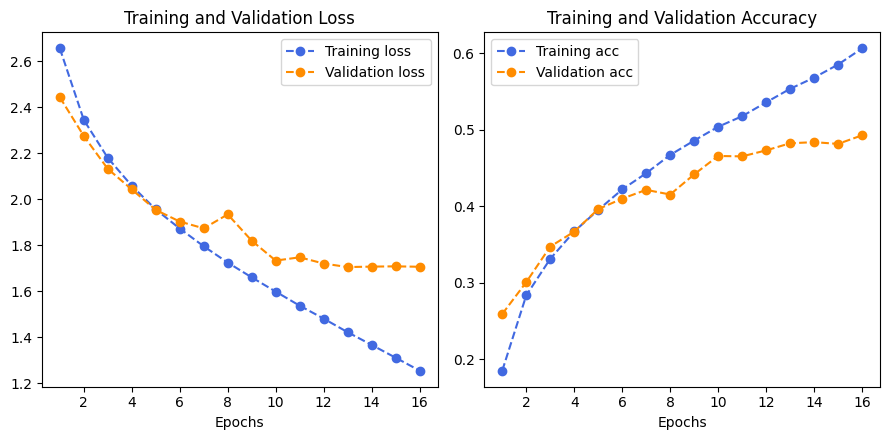

In [ ]:
training_plot(history_cnn)

With padding the generalization performances slightely increases, the validation accuracy is now $0.49$. This is due to the fact that how we have already explained with padding we can exploit all the information in the images, even at the boarders.

## **Stride & Dilation**

Stride and dilation which are two important additional parameters of the convolutional kernel

1. **Stride** specifies a step size when moving the kernel across the signal. 

2. **Dilation** modulates the expansion of the filter without adding weights. Dilation coefficient greater than one increases the units receptive field size without increasing the number of free parameters.

In keras specifying any stride value $!= 1$ is incompatible with specifying any dilation_rate value $!= 1$. For this reason we will specify them in two different trial and we will assess if they improve the performances of the model.



### **Stride**

We built a model with stride = $(2,2)$ in the first and second block of the model


In [ ]:
model = keras.Sequential()

initializer="he_normal"
activation='relu'
stride=(2, 2)

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, strides=stride, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, strides=stride, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers (head of the model)
model.add(layers.Flatten())  
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    
model.add(layers.Dense(20)) 

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 9s 6ms/step - loss: 2.7266 - accuracy: 0.1570 - val_loss: 2.5622 - val_accuracy: 0.2158
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.5005 - accuracy: 0.2308 - val_loss: 2.4527 - val_accuracy: 0.2410
Epoch 3/50
1250/1250 [==============================] - 7s 6ms/step - loss: 2.3850 - accuracy: 0.2640 - val_loss: 2.3699 - val_accuracy: 0.2679
Epoch 4/50
1250/1250 [==============================] - 8s 6ms/step - loss: 2.3047 - accuracy: 0.2858 - val_loss: 2.2650 - val_accuracy: 0.3035
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.2421 - accuracy: 0.3055 - val_loss: 2.2281 - val_accuracy: 0.3069
Epoch 6/50
1250/1250 [==============================] - 7s 6ms/step - loss: 2.1859 - accuracy: 0.3237 - val_loss: 2.1808 - val_accuracy: 0.3287
Epoch 7/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.1351 - accuracy: 0.3398 - val_loss: 2.1578 - val_accuracy:

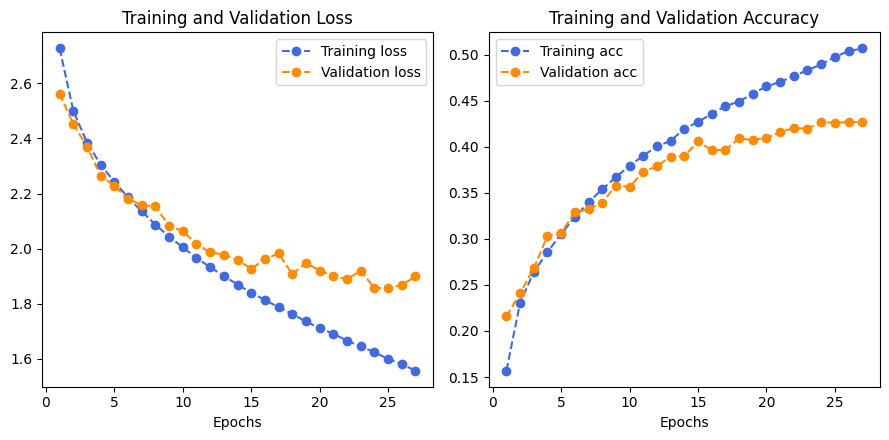

In [ ]:
training_plot(history_cnn)

Stride decrase the generalization performances of our model, the val accuracy reach $0.42$ against the $0.49$ of the the model without stride

### **Dilation**
We specify a model with dilation rate $(2, 2)$ in the first two blocks

In [ ]:
model = keras.Sequential()

initializer="he_normal"
activation='relu'
dilation=(2,2)

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, dilation_rate=dilation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, dilation_rate=dilation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers (head of the model)
model.add(layers.Flatten())  
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    
model.add(layers.Dense(20)) 

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 10s 7ms/step - loss: 2.6272 - accuracy: 0.1920 - val_loss: 2.4317 - val_accuracy: 0.2539
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.3501 - accuracy: 0.2820 - val_loss: 2.2757 - val_accuracy: 0.3044
Epoch 3/50
1250/1250 [==============================] - 7s 5ms/step - loss: 2.2025 - accuracy: 0.3271 - val_loss: 2.1598 - val_accuracy: 0.3404
Epoch 4/50
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0940 - accuracy: 0.3563 - val_loss: 2.0852 - val_accuracy: 0.3621
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0007 - accuracy: 0.3837 - val_loss: 2.0001 - val_accuracy: 0.3846
Epoch 6/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9197 - accuracy: 0.4106 - val_loss: 1.9551 - val_accuracy: 0.4008
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8505 - accuracy: 0.4293 - val_loss: 1.9226 - val_accuracy

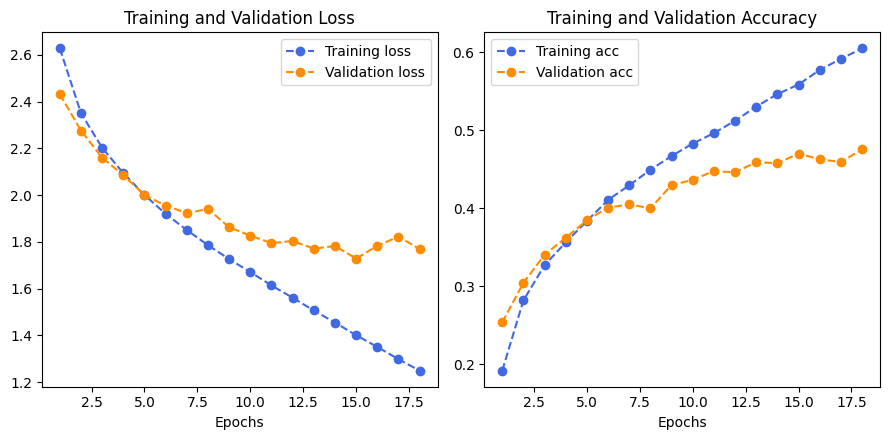

In [ ]:
training_plot(history_cnn)

Also dilation does not increase the performances of the model

## **Increasing the depth of the model**

We try to improve the performances of CNN increasing its depth, which is generally more effective than increasing its width. Deeper networks can learn more complex and abstract features than shallow networks, which can improve their performance on tasks such as image classification.

In the next model we add a $4°$ block with $256$ filters, we add another convolution layer for each block as well.


In [ ]:
model = keras.Sequential()

initializer='HeNormal'
activation='relu'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2))) 

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))

# 4° block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))


# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    
model.add(layers.Dense(20))

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_21 (Normaliza  (None, 32, 32, 3)        7         
 tion)                                                           
                                                                 
 conv2d_128 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_129 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_130 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_131 (Conv2D)         (None, 16, 16, 64)      

The number of Total params increase considerably, in the first model we have $161,492$ while in this deeper model we have $1,306,036$

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 12s 8ms/step - loss: 2.6069 - accuracy: 0.1950 - val_loss: 2.3841 - val_accuracy: 0.2728
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.2764 - accuracy: 0.2973 - val_loss: 2.1735 - val_accuracy: 0.3296
Epoch 3/50
1250/1250 [==============================] - 11s 9ms/step - loss: 2.0807 - accuracy: 0.3562 - val_loss: 2.0254 - val_accuracy: 0.3724
Epoch 4/50
1250/1250 [==============================] - 11s 9ms/step - loss: 1.9446 - accuracy: 0.3957 - val_loss: 1.9901 - val_accuracy: 0.3821
Epoch 5/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.8178 - accuracy: 0.4317 - val_loss: 1.9480 - val_accuracy: 0.3994
Epoch 6/50
1250/1250 [==============================] - 8s 7ms/step - loss: 1.7045 - accuracy: 0.4688 - val_loss: 1.8317 - val_accuracy: 0.4364
Epoch 7/50
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5883 - accuracy: 0.4983 - val_loss: 1.8604 - val_accur

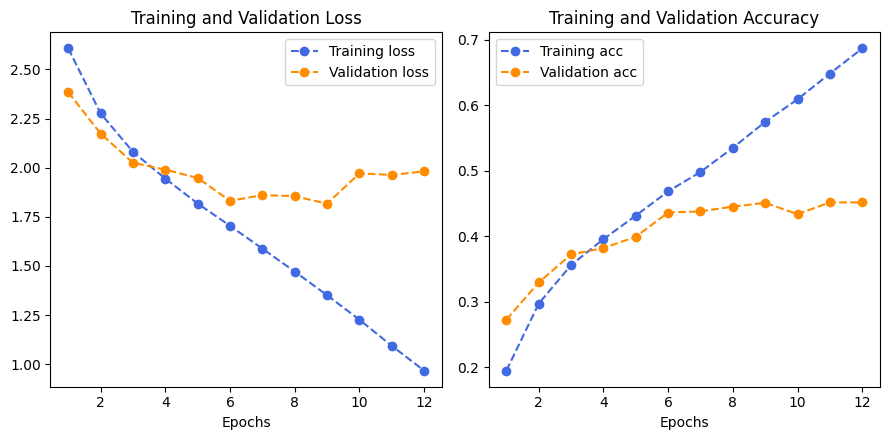

In [ ]:
training_plot(history_cnn)

In this case icreasing the depth of the model do not really lead the increase generalization performances. The model overfit the data after few epochs and the validation accuracy decrease to $0.45$

## **Dropout**

To regularize the CNN and improve its generelization performances we add **dropout** with ``rate=2`` after every CNN block

In [ ]:
model = keras.Sequential()

initializer='HeNormal'
activation='relu'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Dropout(0.2))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 4° block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation=activation, padding="same", kernel_initializer=initializer))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=activation, kernel_initializer=initializer))    
model.add(layers.Dropout(0.2))
model.add(layers.Dense(20))

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_22 (Normaliza  (None, 32, 32, 3)        7         
 tion)                                                           
                                                                 
 conv2d_136 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_137 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_138 (Conv2D)         (None, 16, 16, 64)      

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 13s 9ms/step - loss: 2.8466 - accuracy: 0.1075 - val_loss: 2.6647 - val_accuracy: 0.1857
Epoch 2/50
1250/1250 [==============================] - 12s 9ms/step - loss: 2.6244 - accuracy: 0.1774 - val_loss: 2.5049 - val_accuracy: 0.2430
Epoch 3/50
1250/1250 [==============================] - 10s 8ms/step - loss: 2.4791 - accuracy: 0.2307 - val_loss: 2.4010 - val_accuracy: 0.2581
Epoch 4/50
1250/1250 [==============================] - 12s 9ms/step - loss: 2.3805 - accuracy: 0.2596 - val_loss: 2.2822 - val_accuracy: 0.3029
Epoch 5/50
1250/1250 [==============================] - 13s 11ms/step - loss: 2.2982 - accuracy: 0.2863 - val_loss: 2.2124 - val_accuracy: 0.3132
Epoch 6/50
1250/1250 [==============================] - 14s 11ms/step - loss: 2.2282 - accuracy: 0.3088 - val_loss: 2.1370 - val_accuracy: 0.3366
Epoch 7/50
1250/1250 [==============================] - 13s 11ms/step - loss: 2.1671 - accuracy: 0.3245 - val_loss: 2.0795 - val

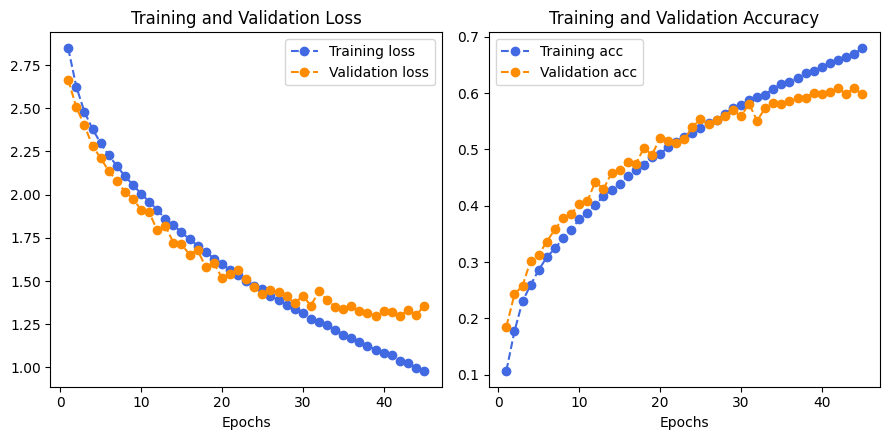

In [ ]:
training_plot(history_cnn)

The generalization performances of the model with dropout has definitely improved. The validation loss drops to a value of $1.2958$ while the validation accuracy rises above $0.60$.



## **Batch Normalization**

**Batch Normalization** consists of a layer that normalizes its inputs. It calculates the mean and the variance of the input to a layer over a mini-batch of training samples and then normalizing the input based on these statistis. This transformation maintains the mean output close to 0 and the output standard deviation close to 1.

Batch normalization can have several positive effects on the training and performance of a CNN:

- **Improved convergence**: Batch normalization can speed up the convergence of a CNN during training by reducing the *internal covariate shift* (changing in the distribution of layer inputs during training).

- **Reduced overfitting**: By normalizing the input to each layer, batch normalization reduces the amount of redundancy and noise in the learned features and can help prevent overfitting.

- **Increased stability**: Batch normalization can increase the stability of a CNN by reducing the impact of changes in the input distribution on the learned features. This can be especially important in large networks where the internal covariate shift can be significant.

We can add batch normalization before or after the application function. We will try both to see what's best in this case.

### **Before the Activation Function**

In [ ]:
model = keras.Sequential()

initializer='HeNormal'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu)) 
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu)) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 4° block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.relu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# Fully connected layer 
model.add(layers.Flatten()) 
model.add(layers.Dense(128, activation='relu', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(20)) 

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 18s 12ms/step - loss: 2.7476 - accuracy: 0.1762 - val_loss: 2.4741 - val_accuracy: 0.2275
Epoch 2/50
1250/1250 [==============================] - 13s 11ms/step - loss: 2.4175 - accuracy: 0.2571 - val_loss: 2.3509 - val_accuracy: 0.2619
Epoch 3/50
1250/1250 [==============================] - 16s 13ms/step - loss: 2.2634 - accuracy: 0.3012 - val_loss: 2.2214 - val_accuracy: 0.3076
Epoch 4/50
1250/1250 [==============================] - 21s 16ms/step - loss: 2.1466 - accuracy: 0.3327 - val_loss: 2.1302 - val_accuracy: 0.3396
Epoch 5/50
1250/1250 [==============================] - 17s 14ms/step - loss: 2.0490 - accuracy: 0.3648 - val_loss: 2.0119 - val_accuracy: 0.3769
Epoch 6/50
1250/1250 [==============================] - 13s 10ms/step - loss: 1.9591 - accuracy: 0.3858 - val_loss: 1.8708 - val_accuracy: 0.4128
Epoch 7/50
1250/1250 [==============================] - 13s 11ms/step - loss: 1.8949 - accuracy: 0.4071 - val_loss: 1.8959 -

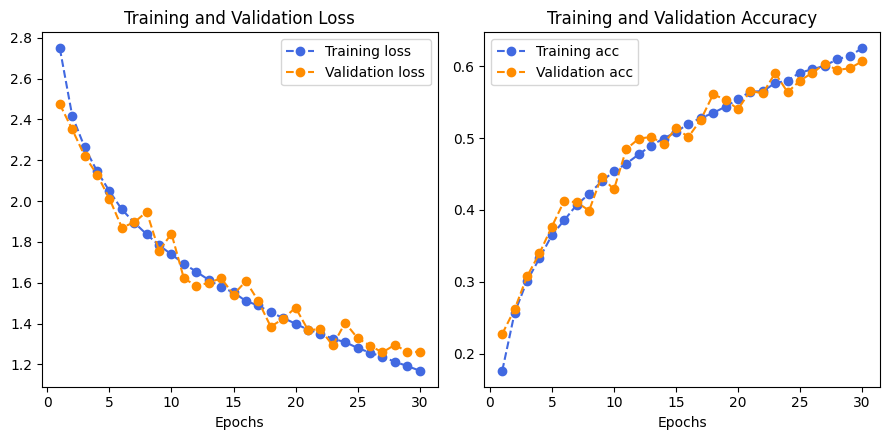

In [ ]:
training_plot(history_cnn)

Observing the plots training and validation loss are very close throughout the duration of training, it means that early stopping probably stops the training of the model before the model really starts to overfit the data. We decided to increase the patience for the next trial.

### **After the Activation Function**

In [ ]:
# Define the model
model = tf.keras.Sequential()

initializer='HeNormal'
activation='relu'

# Add the convolutional layers
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation=activation, padding='same', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))


# Add the fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=activation))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(20))

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_cnn = model.fit(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1250/1250 [==============================] - 17s 11ms/step - loss: 2.6798 - accuracy: 0.2036 - val_loss: 2.2807 - val_accuracy: 0.2946
Epoch 2/50
1250/1250 [==============================] - 14s 11ms/step - loss: 2.3142 - accuracy: 0.2875 - val_loss: 2.1794 - val_accuracy: 0.3189
Epoch 3/50
1250/1250 [==============================] - 14s 11ms/step - loss: 2.1205 - accuracy: 0.3421 - val_loss: 2.0357 - val_accuracy: 0.3700
Epoch 4/50
1250/1250 [==============================] - 17s 13ms/step - loss: 1.9872 - accuracy: 0.3809 - val_loss: 1.9552 - val_accuracy: 0.3947
Epoch 5/50
1250/1250 [==============================] - 13s 10ms/step - loss: 1.8652 - accuracy: 0.4159 - val_loss: 1.8674 - val_accuracy: 0.4185
Epoch 6/50
1250/1250 [==============================] - 13s 11ms/step - loss: 1.7753 - accuracy: 0.4417 - val_loss: 1.7760 - val_accuracy: 0.4391
Epoch 7/50
1250/1250 [==============================] - 14s 11ms/step - loss: 1.6969 - accuracy: 0.4683 - val_loss: 1.7311 -

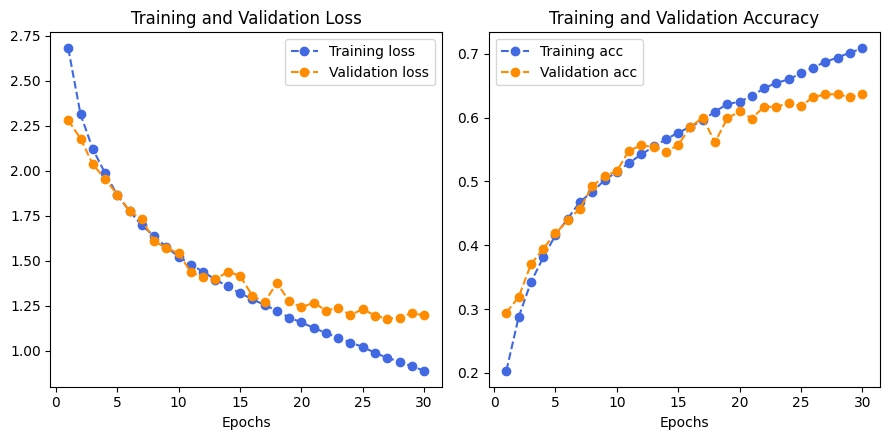

In [ ]:
training_plot(history_cnn)

**Batch Normalization: Before vs After**

Comparing the results of appling batch normalization before or after the activation function we can conclude that in the latter start to overfit data after $20$ epochs, while the former likely after 30 epochs has not already overfitt the data (training loss and validation loss are very close) and probably early stopping has prevent to reach the minimum because of a to small patience. We decide to procede with Batch normalization before the activation function increasing the patience of early stopping.

## **Different Activation Functions - ELU**

One issue we have already explain with ReLU is that if a neuron's output falls below zero during training, it will never activate again. These **dead neurons** can slow down the training process and reduce the model's accuracy. To overcome this problem several activation function were developed such as Leaky Relu, Elu, Selu, Swish and many more.

ELU has been shown to outperform ReLU on certain tasks, such as image classification, due to its **improved gradient propagation** and **reduced bias shift**.

In the model below we will use elu activation function.

In [ ]:
model = keras.Sequential()

initializer='HeNormal'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu)) 
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu)) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 4° block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# Fully connected layer 
model.add(layers.Flatten()) 
model.add(layers.Dense(128, activation='elu', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(20)) 

In [ ]:
# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_cnn = model.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
1250/1250 [==============================] - 21s 15ms/step - loss: 2.6605 - accuracy: 0.2110 - val_loss: 2.2925 - val_accuracy: 0.2985
Epoch 2/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2923 - accuracy: 0.2928 - val_loss: 2.1491 - val_accuracy: 0.3383
Epoch 3/100
1250/1250 [==============================] - 13s 11ms/step - loss: 2.0940 - accuracy: 0.3474 - val_loss: 2.0926 - val_accuracy: 0.3523
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9792 - accuracy: 0.3835 - val_loss: 1.8276 - val_accuracy: 0.4299
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8822 - accuracy: 0.4103 - val_loss: 1.8244 - val_accuracy: 0.4338
Epoch 6/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.8133 - accuracy: 0.4287 - val_loss: 1.7769 - val_accuracy: 0.4461
Epoch 7/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.7500 - accuracy: 0.4521 - val_loss: 1

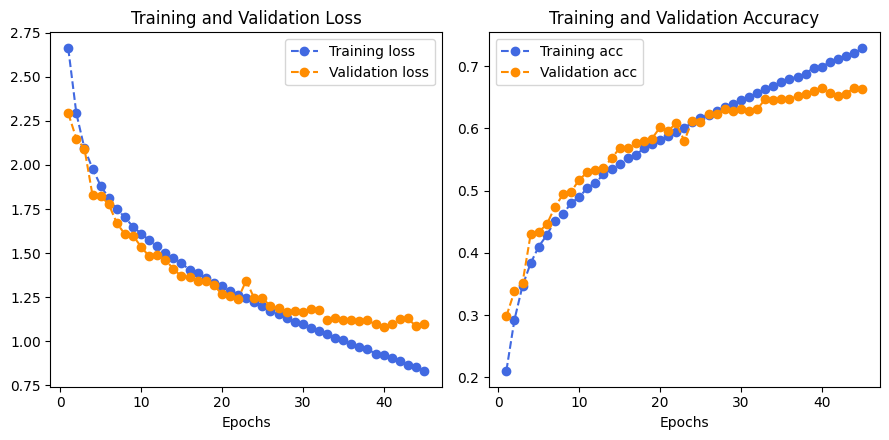

In [ ]:
training_plot(history_cnn)

With elu the model reach quite good results for our task. The accuracy reach $0.66$ which is a quite satisfactory result for the CIFAR-100 dataset with coarse labels

## **Optimizers**
As last we change the optimizer. Adam is the default choice in keras tensorflow. 

In [ ]:
model = keras.Sequential()

initializer='HeNormal'

# Feature Extractors blocks
# 1° block
model.add(layers.Normalization(input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu)) 
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer=initializer)) 
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu)) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 2° block
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 3° block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# 4° block
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Activation(tf.keras.activations.elu))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# Fully connected layer 
model.add(layers.Flatten()) 
model.add(layers.Dense(128, activation='elu', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))  
model.add(layers.Dense(20)) 

In [ ]:
# Compile the model
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history_cnn = model.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[callback])

Epoch 1/100
1250/1250 [==============================] - 20s 11ms/step - loss: 2.3988 - accuracy: 0.2709 - val_loss: 2.0290 - val_accuracy: 0.3741
Epoch 2/100
1250/1250 [==============================] - 17s 13ms/step - loss: 1.9199 - accuracy: 0.3995 - val_loss: 1.7293 - val_accuracy: 0.4590
Epoch 3/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.6922 - accuracy: 0.4640 - val_loss: 1.5223 - val_accuracy: 0.5141
Epoch 4/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.5532 - accuracy: 0.5092 - val_loss: 1.5126 - val_accuracy: 0.5218
Epoch 5/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.4276 - accuracy: 0.5467 - val_loss: 1.3519 - val_accuracy: 0.5684
Epoch 6/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.3314 - accuracy: 0.5737 - val_loss: 1.3327 - val_accuracy: 0.5787
Epoch 7/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.2378 - accuracy: 0.6035 - val_loss: 1

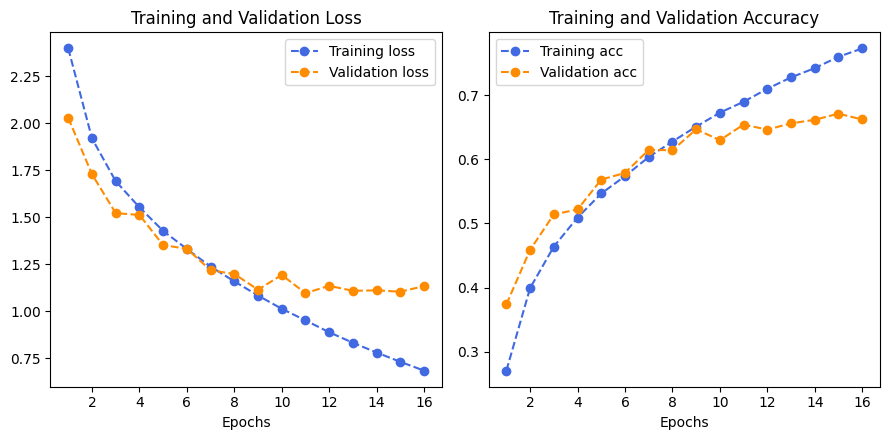

In [ ]:
training_plot(history_cnn)

Adam allow to speed up the training while mantaining the performances of the model. It takes just $16$ epochs to converge. 

## **Evaluating the model on the test set**

We conclude by evaluating the performances of the last (and best) model we have built on the test set.

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_images, test_labels, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 1s 9ms/step - loss: 1.1320 - accuracy: 0.6629
test loss, test acc: [1.1320226192474365, 0.6628999710083008]


The accuracy on the test set is $0,66$. A good results for the dataset.

---
## **Conclusion**

We have seen that CNN achieve better generalization performances on an image classification task such as CIFAR-100 with coarse label wrt a MLP. 

The best model achieves $0.66$ accuracy on the test set versus $0.37$ of MLP. With CNN we have seen how an increase in performance occurs with a deeper structure, using activation functions which overcome the problem of *dead neurons* of ReLU such as ELU.
We have also seen that batch normalization before the application of the activation function is more effective than using it after the activation function.
Dropout allow to regularize the model and achive better generalization performances.
Adam is a better optimizers than SGD because it allows to speed up the convergence of the model while mantains its performances.